In [3]:
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import numpy as np
import random

In [2]:
sbn.set()

# An Introduction to Stochastic Simulation of Chemical Kinetics

Let us consider a system with $N$ chemical species $\{S_{1},S_{2},\dots,S_{N}\}$ with $X_{i}$ number of molecules of species $S_{i}$. From a classical mechanics viewpoint we assume the chemical kinetics as a deterministic system, then given a initial point we can describe how the distribution of species will be in any point on the future. Such behavior is ruled by Reaction-Rate equations, a set of coupled, first-order, ordinary diferential equations of the forms:
$$
\displaystyle\frac{dX_{i}}{dt} = f_{i}\left(X_{1},X_{2},\dots,X_{N}\right)
$$
Where each $f_{i}$ is inferred from a specific reaction. 

It is remarkable to note that for system of test-tube size or larger then RRE approximation works quites well because molecular effects when larger populations can be considered as an average of some distribution and then descreteness and stochastisity are negligible. When the system is smaller Stochasithc Chemical Kinetics attemps to describe the evolution of populations over time of a well-stirred chemical reacting systems confined to a constant volume $\Omega$ and in thermal (but not chemical) equilibrium at some constante temperature $T$.

Stochasitc Simulation Algorithm (SSA) is a Monte-Carlo precedure for numerically generating time trajectories of molecular populations in _exact_ accordance with the Chemical Master Equation (CME). It is possible to summarize the SSA as following:
1. Initialize the time $t=t_{0}$ and the system's state $\mathbf{x} = \mathbf{x_{0}}$
2. With the system in state $\mathbf{x}$ and time $t$, evaluate all the *propensity functions* $a_{j}(\mathbf{x})$ and their sum $a_{0}(\mathbf{x}) = \displaystyle\sum_{j'=1}^{M} a_{j'}(\mathbf{x})$
1. Generate values for $\tau$ and $j$ some Monte Carlo produre as direct method (so called direct simulation too) where there are generated two random variables $r_{1},\, r_{2}$ from a $U(0,1)$ en then $\tau = \displaystyle\frac{1}{a_{0}(\mathbf{x})}\ln{\left(\frac{1}{r_{1}}\right)}$ and $j = \min\left\{ j' \displaystyle|\sum_{k=1}^{j'} a_{k}(\mathbf{x}) > a_{0}(\mathbf{x}) \right\}$
1. Effect the next reaction by replacing $t \leftarrow t + r$ and $\mathbf{x} \leftarrow \mathbf{x} + \mathbf{\nu_{j}}$
1. Record $(\mathbf{x},t)$. Return to Step 2 or else end the simulation. 

# Some examples

## A first example: A simple reaction

Let us consider the simple reaction:
$$
S \xrightarrow{\;\; C \;\; } \emptyset
$$
The RRE equation is then
$$
\displaystyle\frac{dX}{dt} = -cX
$$
If we assume a initial condition $X(t=t_{0}) = x_{0}$ then we have the following general solution:
$$
X(t) = x_{0} e^{-ct}
$$

On the other hand, the propensity funtion is $a(x)=cx$ and the state change vector is simply $\nu = -1$

Let us suppose $X(0)=100$ and $c=1$ and let us develop the SSA with direct method. 

In [221]:
def SSA(x,t,a,v,t_max,seed = 42):
    """
    A toy version of the SSA described in the notebook
    
    Params
    ---------
    x : array_like
        A vector of states vectors, if len(x)>1 then is going to be used x[-1]
    t : array_like
        A vecttor of timesteps, t0 = t[-1]
    a : func
        The vectorial function form of all propensity functions
    v : array_like
        The state change vector or matrix
    t_max : float
        The condition time to stop
    seed : int
        Seed to secure reproducibility
    """
    if seed!=None:
        np.random.seed(seed)

    while True:
        x0,t0 = x[-1],t[-1]
        
        if np.sum(a(2),axis=0).dtype == 'int64':
            a_vector = np.asarray([np.sum(a(x0),axis=0)])
        else:
            a_vector = a(x0)
        
        
        a_0 = np.sum(a_vector)
        
        if a_0 == 0: #first stop condition
            break
        
        
        #tau = (1/a_0)*np.log(1/np.random.uniform())
        # Tau dist prob of generating function is a_{0}*exp(-tau*a_{0}) therefore the following is more stable than the later tau-generator
        tau = np.random.exponential(scale=1/a_0)
        
        #r,j = np.random.uniform(), 1
        #while True:
        #    if np.sum(a_vector[:j]) > r*a_0:
        #        break
        #    else:
        #        j+=1
        
        # the dist prob of generating function of j is a_{j}/a_{0}, a point probability so the following is more stable than the later j-generator
        j = random.choices(np.arange(len(a_vector)),weights=a_vector/a_0)[0]
                
        t = np.append(t,t0+tau)
        x = np.append(x,x0+v[j])
        #print(t0+tau,a_vector,a_0,j)
        if t0+tau>=t_max:
            break
        
    return x,t

In [195]:
a = lambda x: 1*x
v = [-1]

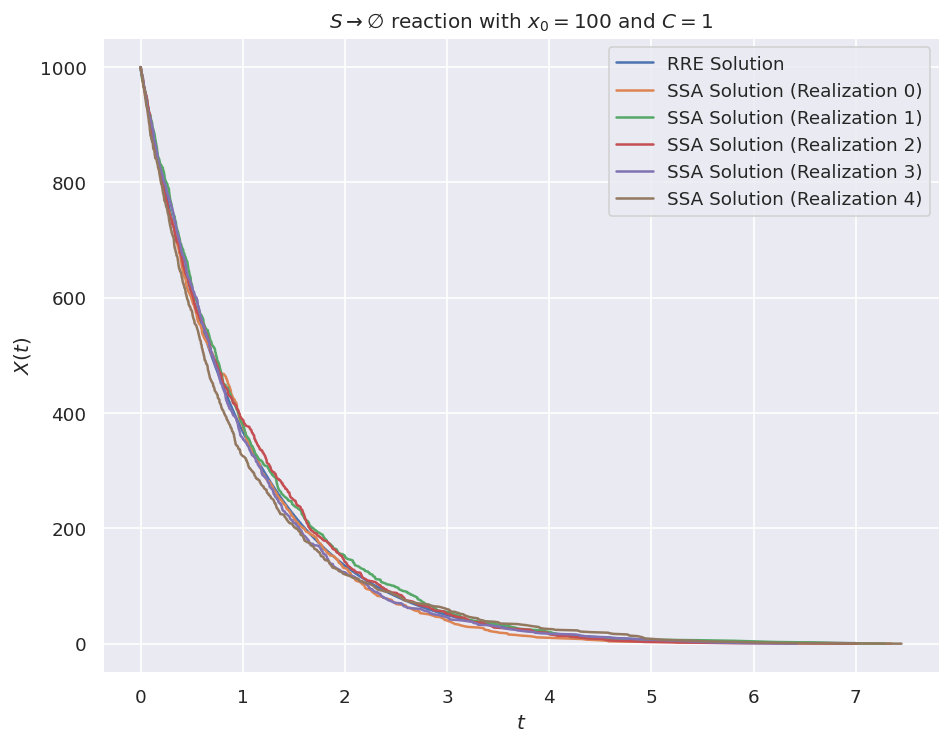

In [196]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(9,7))
ax.plot(np.linspace(0,7,1000),1000*np.exp(-1*np.linspace(0,7,1000)),label='RRE Solution')
for i in range(5):
    x,t = SSA(x=[1000],t=[0],a=a,v=v,t_max=7,seed=42+i)
    ax.plot(t,x,label='SSA Solution (Realization {})'.format(i))

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X(t)$')
ax.set_title(r'$S \rightarrow \emptyset$ reaction with $x_{0}=100$ and $C = 1$')

ax.legend()

plt.show()

Let us note that the RRE solution behave as the mean of many repetitions of SSA solution

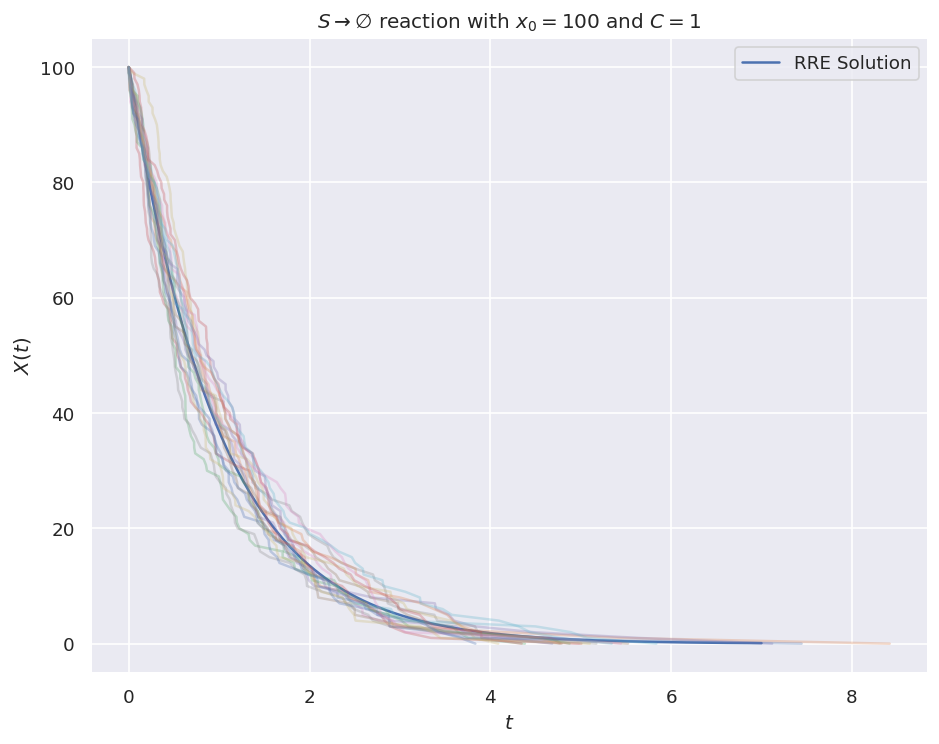

In [165]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(9,7))
ax.plot(np.linspace(0,7,1000),100*np.exp(-1*np.linspace(0,7,1000)),label='RRE Solution')
for i in range(20):
    x,t = SSA(x=[100],t=[0],a=a,v=v,t_max=7,seed=None)
    ax.plot(t,x,alpha=0.3)

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X(t)$')
ax.set_title(r'$S \rightarrow \emptyset$ reaction with $x_{0}=100$ and $C = 1$')

ax.legend()

plt.show()

## Second example, a more complicated reaction

A most complicated reaction is as following
$$
\begin{eqnarray}
&\bar{X}& + Y \xrightarrow{\;\; C_{1} \;\; } 2Y \\
&2Y& \xrightarrow{\;\; C_{2} \;\; } Z
\end{eqnarray}
$$
Where $\bar{X}$ denotes that the molecular population  is constant over time.

In the context of RSE we obtain for Y
$$
\displaystyle\frac{dY}{dt} = c_1 [\bar{X}] [Y] - 2 c_{2} [Y]^2
$$

But in the context of SSA we got a state change vector $\mathbf{\nu} = [1,-1]$ and $a_{1}(Y) = c_{1}[\bar{X}][Y(t)]$, $a_{2}(Y) =\displaystyle\frac{c_{2}}{2}[Y(t)]([Y(t)]-1)$. 

In [253]:
def R(Y,k,c):
    return np.asarray([Y*k,0.5*Y*(Y-1)*c])

To reproduce the results we use $k=c_{1}[\bar{X}] = 5$ and $c_{2}=0.005$ with two conditions $y_{0}=10$ and $y_{0}=3000$

In [254]:
a = lambda y : R(y,k=5,c=0.005)
v = [+1,-1]

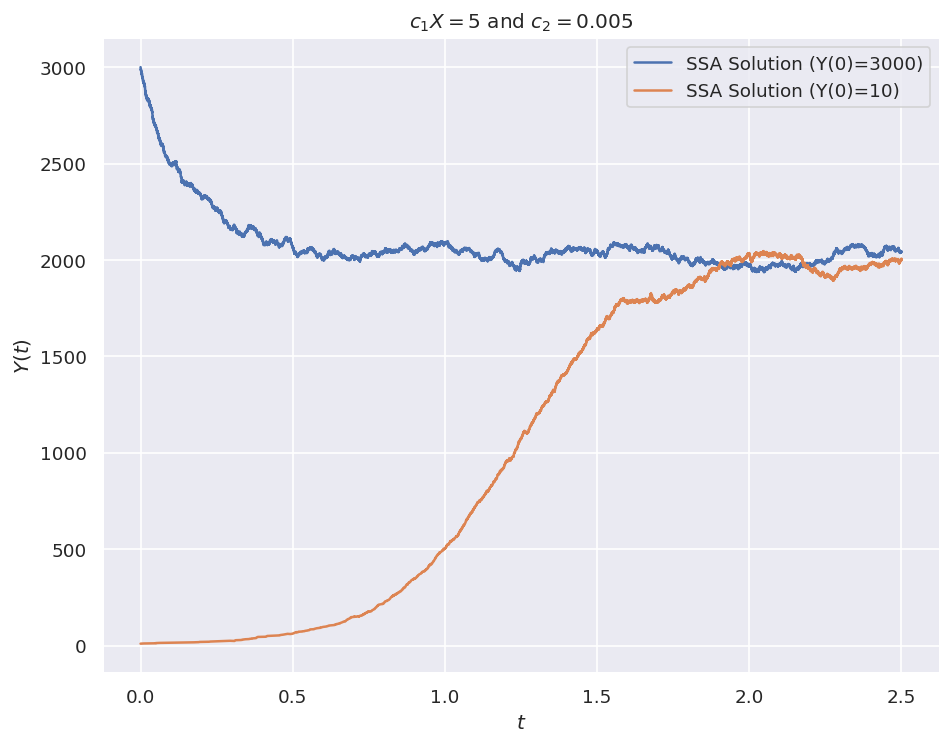

In [255]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(9,7))

for i in [3000,10]:
    x,t = SSA(x=[i],t=[0],a=a,v=v,t_max=2.5,seed=None)
    ax.plot(t,x,label='SSA Solution (Y(0)={})'.format(i))

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$Y(t)$')
ax.set_title(r'$c_{1}X = 5$ and $c_{2}=0.005$')

ax.legend()

plt.show()

Again, to reproduce results we use $k=c_{1}[\bar{X}] = 5$ and $c_{2}=0.00125$ with two conditions $y_{0}=40$ and $y_{0}=12000$

In [240]:
a = lambda y : R(y,k=5,c=0.00125)
v = [+1,-1]

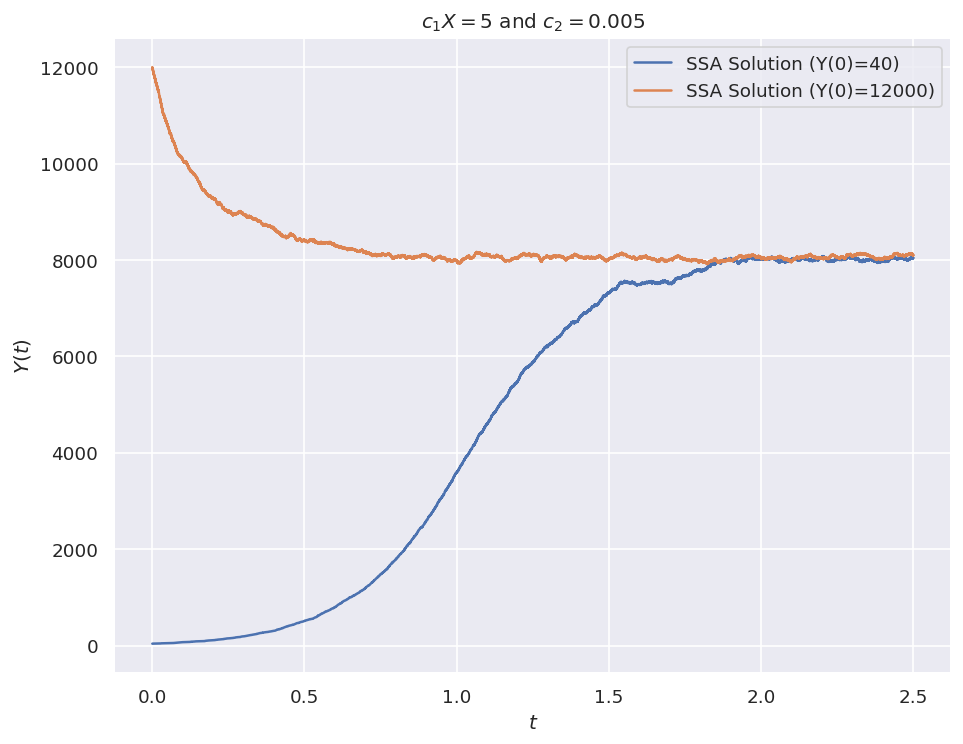

In [243]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(9,7))

for i in [40,12000]:
    x,t = SSA(x=[i],t=[0],a=a,v=v,t_max=2.5)
    ax.plot(t,x,label='SSA Solution (Y(0)={})'.format(i))

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$Y(t)$')
ax.set_title(r'$c_{1}X = 5$ and $c_{2}=0.00125$')

ax.legend()

plt.show()